# 1-2,图片数据建模流程范例

In [1]:
!pip3 install torchvision
!pip3 install torchmetrics 

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import torch 
import torchvision 
import torchkeras 
import torchmetrics
print("torch.__version__ = ", torch.__version__)
print("torchvision.__version__ = ", torchvision.__version__) 
print("torchkeras.__version__ = ", torchkeras.__version__) 
print("torchmetrics.__version__ = ", torchmetrics.__version__) 

torch.__version__ =  2.5.1
torchvision.__version__ =  0.20.1
torchkeras.__version__ =  4.0.2
torchmetrics.__version__ =  1.6.1


### 一，准备数据

cifar2数据集为cifar10数据集的子集，只包括前两种类别airplane和automobile。

训练集有airplane和automobile图片各5000张，测试集有airplane和automobile图片各1000张。

cifar2任务的目标是训练一个模型来对飞机airplane和机动车automobile两种图片进行分类。

我们准备的Cifar2数据集的文件结构如下所示。

![](./data/cifar2.jpg)

在Pytorch中构建图片数据管道通常有几种方法。

1. 使用 torchvision.datasets.ImageFolder
适用场景: 如果你的图片数据是按照类别存放在不同的文件夹中，这种方法非常方便。ImageFolder 会自动根据文件夹结构为图片分配标签。

优点:
- 简单易用，适合标准的数据集结构。
- 内置了数据增强和预处理功能。

缺点:
- 灵活性较低，不适合非标准的数据集结构。

2. 继承 torch.utils.data.Dataset 实现自定义读取逻辑

适用场景: 如果你的数据集结构比较复杂，或者你需要对数据进行特定的预处理，这种方法是最灵活的。

优点:

完全自定义数据加载和处理逻辑。
适用于任何类型的数据集（图片、文本、音频等）。
缺点:

需要编写更多的代码，相对复杂。

3. 读取用户自定义数据集的通用方法
适用场景: 这种方法适用于需要处理多种类型数据（如图片和文本）的复杂任务。

优点:

高度灵活，可以处理多种数据类型。
可以结合多种数据加载和处理逻辑。
缺点:

需要更多的代码和更复杂的逻辑。


In [3]:
# 导入必要的库
import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms as T
from torchvision import datasets 

In [4]:
# 定义图片的转换操作
# T.Compose 用于将多个转换操作组合在一起
# T.ToTensor() 将图片从PIL格式或NumPy数组转换为PyTorch张量，并将像素值归一化到 [0, 1] 范围
transform_img = T.Compose([T.ToTensor()])

# 定义标签的转换函数
# 这个函数将标签转换为一个包含单个元素的PyTorch张量，并将其转换为浮点数类型
def transform_label(x):
    return torch.tensor([x]).float()


In [5]:
# 使用 ImageFolder 加载训练数据集
# ImageFolder 会自动根据文件夹结构为图片分配标签
# "./eat_pytorch_datasets/cifar2/train/" 是训练数据集所在的路径
# transform = transform_img 指定了图片的转换操作
# target_transform = transform_label 指定了标签的转换操作
ds_train = datasets.ImageFolder("./eat_pytorch_datasets/cifar2/train/",
                                transform = transform_img, target_transform = transform_label)

# 使用 ImageFolder 加载验证数据集
# "./eat_pytorch_datasets/cifar2/test/" 是验证数据集所在的路径
# transform = transform_img 指定了图片的转换操作
# target_transform = transform_label 指定了标签的转换操作
ds_val = datasets.ImageFolder("./eat_pytorch_datasets/cifar2/test/",
                              transform = transform_img, target_transform = transform_label)
# 打印训练数据集的类别到索引的映射
# class_to_idx 是一个字典，键是类别名称，值是对应的索引
print(ds_train.class_to_idx)


{'0_airplane': 0, '1_automobile': 1}


In [6]:
# 使用 DataLoader 加载训练数据集
# batch_size = 50 指定每个批次包含50个样本
# shuffle = True 表示在每个epoch开始时打乱数据顺序
dl_train = DataLoader(ds_train, batch_size = 50, shuffle = True)

# 使用 DataLoader 加载验证数据集
# batch_size = 50 指定每个批次包含50个样本
# shuffle = False 表示不进行数据打乱
dl_val = DataLoader(ds_val, batch_size = 50, shuffle = False)


`batch_size` 是深度学习训练中的一个重要超参数，它定义了每次迭代时模型处理的样本数量。理解 `batch_size` 的作用对优化训练过程和模型性能非常重要。以下是对 `batch_size` 的详细解释：

---

## **1. `batch_size` 的作用**

### **1.1 定义**
`batch_size` 表示每次训练迭代中模型同时处理的样本数量。例如：
- 如果 `batch_size=50`，则每次迭代会使用 50 个样本来更新模型参数。

### **1.2 主要作用**
- **梯度计算：**  
  在深度学习中，模型通过反向传播计算梯度来更新参数。`batch_size` 决定了每次梯度更新时使用的样本数量。
  - 如果 `batch_size=1`，则每次使用单个样本计算梯度（称为 **随机梯度下降，SGD**）。
  - 如果 `batch_size=全部样本`，则每次使用所有样本计算梯度（称为 **批量梯度下降，BGD**）。
  - 如果 `batch_size` 是介于 1 和全部样本之间的值，则称为 **小批量梯度下降（Mini-batch Gradient Descent）**。

- **内存使用：**  
  `batch_size` 直接影响训练时的内存占用。较大的 `batch_size` 需要更多的内存来存储数据和中间计算结果。

- **训练速度：**  
  - 较大的 `batch_size` 可以利用 GPU 的并行计算能力，加速训练过程。
  - 但过大的 `batch_size` 可能会导致单次迭代时间过长。

- **模型性能：**  
  `batch_size` 会影响模型的收敛速度和最终性能：
  - 较小的 `batch_size` 会引入更多的噪声（因为每次更新基于少量样本），可能导致训练不稳定，但有助于模型逃离局部最优。
  - 较大的 `batch_size` 会提供更稳定的梯度估计，但可能导致模型陷入局部最优。

---

## **2. `batch_size` 的选择**

### **2.1 常见选择**
- **较小的 `batch_size`（如 16、32、64）：**  
  适用于以下情况：
  - 数据集较小。
  - 模型较复杂，内存有限。
  - 希望模型有更好的泛化能力。

- **较大的 `batch_size`（如 128、256、512）：**  
  适用于以下情况：
  - 数据集较大。
  - 硬件资源充足（如 GPU 内存较大）。
  - 希望加速训练过程。

### **2.2 经验法则**
- 通常从 `batch_size=32` 开始，然后根据硬件资源和训练效果进行调整。
- `batch_size` 通常是 2 的幂次方（如 16、32、64），因为 GPU 对这类数值的计算效率更高。

---

## **3. 代码中的 `batch_size`**

在你的代码中：
```python
dl_train = DataLoader(ds_train, batch_size=50, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=50, shuffle=False)
```

- **`batch_size=50`** 表示每次迭代会使用 50 个样本来更新模型参数。
- **`shuffle=True`** 表示在每个 epoch 开始时打乱训练数据的顺序，以避免模型学习到数据的顺序信息。
- **`shuffle=False`** 表示验证数据不打乱，因为验证过程不需要随机性。

---

## **4. `batch_size` 的影响**

### **4.1 训练时间**
- 较大的 `batch_size` 会减少每个 epoch 的迭代次数，但每次迭代的计算时间会增加。
- 较小的 `batch_size` 会增加每个 epoch 的迭代次数，但每次迭代的计算时间会减少。

### **4.2 模型性能**
- 较小的 `batch_size` 可能导致训练不稳定，但有助于模型逃离局部最优。
- 较大的 `batch_size` 可能导致模型陷入局部最优，但训练过程更稳定。

### **4.3 内存占用**
- 较大的 `batch_size` 会占用更多的内存，可能导致内存不足（尤其是 GPU 内存）。
- 较小的 `batch_size` 内存占用较少，但可能无法充分利用硬件资源。

---

## **5. 总结**

- **`batch_size` 是控制每次迭代样本数量的超参数。**
- 它的选择需要权衡训练速度、内存占用和模型性能。
- 通常从 `batch_size=32` 开始，然后根据实际情况调整。
- 在你的代码中，`batch_size=50` 是一个合理的默认值，但可以根据硬件资源和训练效果进一步优化。

如果你有其他问题，欢迎随时提问！

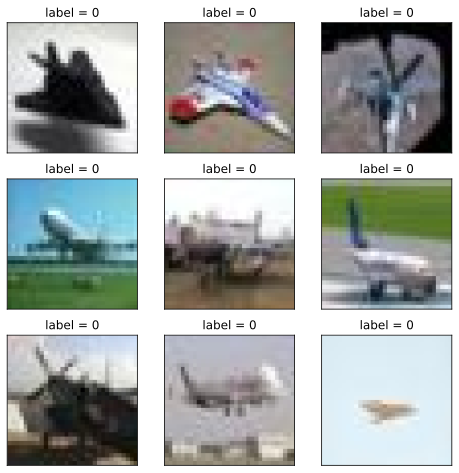

In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#查看部分样本
from matplotlib import pyplot as plt 

plt.figure(figsize=(8,8)) 
for i in range(9):
    img,label = ds_train[i]
    img = img.permute(1,2,0)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label.item())
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()


In [12]:
# Pytorch的图片默认顺序是 Batch,Channel,Width,Height
for features,labels in dl_train:
    print(features.shape,labels.shape) 
    break
    

torch.Size([50, 3, 32, 32]) torch.Size([50, 1])


深度学习中，准备数据是至关重要的一步，直接影响模型的训练效果和性能。以下是准备数据部分需要定义和整理的关键内容，以及每个部分的详细说明：

---

## **准备数据部分需要定义的内容**

### **1. 数据加载**
- **目标：** 将原始数据加载到程序中。
- **操作：**
  - 从文件（如 CSV、JSON、数据库）中加载数据。
  - 使用 Pandas、NumPy 等工具处理数据。
- **示例：**
  ```python
  import pandas as pd
  data = pd.read_csv('titanic.csv')  # 加载数据集
  ```

---

### **2. 数据预处理**
- **目标：** 将原始数据转换为模型可以处理的格式。
- **操作：**
  - **处理缺失值：** 填充或删除缺失值。
  - **特征编码：** 将类别特征转换为数值（如 One-Hot 编码、Label Encoding）。
  - **特征缩放：** 标准化或归一化数值特征。
  - **特征选择：** 选择对模型训练有用的特征。
- **示例：**
  ```python
  # 处理缺失值
  data['Age'].fillna(data['Age'].median(), inplace=True)

  # 特征编码
  data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})

  # 特征缩放
  from sklearn.preprocessing import StandardScaler
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  ```

---

### **3. 数据集划分**
- **目标：** 将数据集划分为训练集、验证集和测试集。
- **操作：**
  - 使用 `train_test_split` 或其他方法划分数据。
  - 通常的比例是：训练集 70%，验证集 15%，测试集 15%。
- **示例：**
  ```python
  from sklearn.model_selection import train_test_split
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
  ```

---

### **4. 转换为 PyTorch 张量**
- **目标：** 将数据转换为 PyTorch 模型可以处理的格式（Tensor）。
- **操作：**
  - 使用 `torch.tensor()` 将 NumPy 数组或 Pandas DataFrame 转换为 PyTorch 张量。
  - 确保数据类型正确（如 `float32` 用于特征，`int64` 用于标签）。
- **示例：**
  ```python
  import torch
  X_train = torch.tensor(X_train, dtype=torch.float32)
  y_train = torch.tensor(y_train.values, dtype=torch.float32)
  ```

---

### **5. 创建 DataLoader**
- **目标：** 将数据组织成批次（batch），便于训练时迭代。
- **操作：**
  - 使用 `torch.utils.data.TensorDataset` 将特征和标签打包成数据集。
  - 使用 `torch.utils.data.DataLoader` 创建数据加载器。
  - 定义 `batch_size` 和 `shuffle` 参数。
- **示例：**
  ```python
  from torch.utils.data import DataLoader, TensorDataset

  # 创建数据集
  train_dataset = TensorDataset(X_train, y_train)
  val_dataset = TensorDataset(X_val, y_val)

  # 创建 DataLoader
  batch_size = 50
  dl_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  dl_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
  ```

---

## **准备数据部分的完整代码示例**

```python
# 1. 数据加载
import pandas as pd
data = pd.read_csv('titanic.csv')

# 2. 数据预处理
# 处理缺失值
data['Age'].fillna(data['Age'].median(), inplace=True)

# 特征编码
data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})

# 特征选择
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
target = 'Survived'
X = data[features]
y = data[target]

# 特征缩放
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 3. 数据集划分
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. 转换为 PyTorch 张量
import torch
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
y_val = torch.tensor(y_val.values, dtype=torch.float32).reshape(-1, 1)

# 5. 创建 DataLoader
from torch.utils.data import DataLoader, TensorDataset

# 创建数据集
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# 创建 DataLoader
batch_size = 50
dl_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
```

---

## **关键点总结**

| **步骤**          | **内容**                                                                 | **工具/方法**                             |
|-------------------|-------------------------------------------------------------------------|-------------------------------------------|
| **数据加载**       | 从文件或数据库中加载原始数据                                             | Pandas (`pd.read_csv`)                    |
| **数据预处理**     | 处理缺失值、特征编码、特征缩放、特征选择                                   | Pandas、Scikit-learn (`StandardScaler`)   |
| **数据集划分**     | 将数据集划分为训练集、验证集和测试集                                       | Scikit-learn (`train_test_split`)         |
| **转换为张量**     | 将数据转换为 PyTorch 张量                                                | PyTorch (`torch.tensor`)                  |
| **创建 DataLoader**| 将数据组织成批次，便于训练时迭代                                          | PyTorch (`TensorDataset`, `DataLoader`)   |

---

## **注意事项**
1. **数据质量：** 确保数据清洗和预处理步骤正确，避免引入噪声。
2. **数据划分：** 验证集和测试集的划分比例要合理，通常验证集用于调参，测试集用于最终评估。
3. **`batch_size` 选择：** 根据硬件资源和数据集大小选择合适的 `batch_size`。
4. **随机性控制：** 使用 `random_state` 确保数据集划分和打乱顺序的可重复性。

希望这份整理对你有帮助！如果有其他问题，欢迎随时提问。

### 二，定义模型

不客气！你提到的三种模型定义方式都非常重要，它们各有优缺点，适用于不同的场景。接下来我会详细分析这三种方式，并给出推荐使用的场景。

---

## **1. `nn.Sequential`：按层顺序构建模型**

### **特点**
- **简单直观：** 按顺序逐层定义模型，适合简单的线性结构。
- **代码简洁：** 不需要定义 `forward` 方法，PyTorch 会自动处理前向传播。
- **限制：** 只能用于简单的、按顺序堆叠的模型结构，无法处理复杂的逻辑（如分支、循环）。

### **适用场景**
- 模型结构简单，层与层之间是严格的顺序关系。
- 快速搭建原型或测试简单模型。

### **示例**
```python
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(10, 20),  # 输入层
    nn.ReLU(),          # 激活函数
    nn.Linear(20, 1),   # 输出层
    nn.Sigmoid()        # 激活函数
)
```

---

## **2. 继承 `nn.Module` 基类构建自定义模型**

### **特点**
- **灵活性强：** 可以定义复杂的模型结构，支持分支、循环等逻辑。
- **可复用性高：** 可以将模型封装为类，便于复用和扩展。
- **代码量稍多：** 需要手动定义 `__init__` 和 `forward` 方法。

### **适用场景**
- 模型结构复杂，包含分支、循环或自定义逻辑。
- 需要复用模型或扩展功能。

### **示例**
```python
import torch.nn as nn

class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.linear1 = nn.Linear(10, 20)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(20, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.sigmoid(x)
        return x

model = CustomModel()
```

---

## **3. 继承 `nn.Module` 并辅助应用模型容器**

### **特点**
- **模块化设计：** 使用 `nn.Sequential`、`nn.ModuleList` 或 `nn.ModuleDict` 封装模型组件，提高代码可读性和可维护性。
- **灵活性高：** 既可以定义复杂结构，又可以利用容器简化代码。
- **代码量适中：** 比直接继承 `nn.Module` 更简洁，但比 `nn.Sequential` 稍复杂。

### **适用场景**
- 模型结构复杂，但某些部分可以模块化。
- 需要动态调整模型结构（如使用 `nn.ModuleList`）。

### **示例**
```python
import torch.nn as nn

class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.features = nn.Sequential(
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 10)
        )
        self.classifier = nn.Sequential(
            nn.Linear(10, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = CustomModel()
```

---

## **推荐使用哪种形式？**

### **1. 简单模型**
- 如果模型结构非常简单（如全连接网络、简单的卷积网络），推荐使用 **`nn.Sequential`**。
- 优点：代码简洁，易于理解。

### **2. 复杂模型**
- 如果模型结构复杂（如包含分支、循环或自定义逻辑），推荐使用 **继承 `nn.Module` 基类**。
- 优点：灵活性强，支持复杂逻辑。

### **3. 模块化设计**
- 如果模型结构复杂但可以模块化（如特征提取部分和分类部分分离），推荐使用 **继承 `nn.Module` 并辅助应用模型容器**。
- 优点：代码可读性和可维护性高。

---

## **总结**

| **方法**                     | **适用场景**                         | **优点**                          | **缺点**                          |
|------------------------------|-------------------------------------|-----------------------------------|-----------------------------------|
| **`nn.Sequential`**           | 简单模型，线性结构                   | 代码简洁，易于理解                | 无法处理复杂逻辑                  |
| **继承 `nn.Module`**          | 复杂模型，自定义逻辑                 | 灵活性强，支持复杂逻辑            | 代码量稍多                        |
| **继承 `nn.Module` + 容器**   | 复杂但可模块化的模型                 | 模块化设计，代码可维护性高        | 代码量适中                        |

---

## **最终建议**
- **初学者：** 从 `nn.Sequential` 开始，熟悉 PyTorch 的基本用法。
- **中级用户：** 尝试继承 `nn.Module` 构建自定义模型，掌握复杂模型的实现方法。
- **高级用户：** 使用模型容器（如 `nn.Sequential`、`nn.ModuleList`、`nn.ModuleDict`）优化代码结构，提高可读性和可维护性。

希望这份整理对你有帮助！如果有其他问题，欢迎随时提问。

In [13]:
# 测试 AdaptiveMaxPool2d 的效果
import torch
import torch.nn as nn

# 定义 AdaptiveMaxPool2d 层，输出大小为 (1, 1)
pool = nn.AdaptiveMaxPool2d((1,1))

# 创建一个随机张量，形状为 (10, 8, 32, 32)
# 10: 批次大小 (batch_size)
# 8: 通道数 (channels)
# 32: 高度 (height)
# 32: 宽度 (width)
t = torch.randn(10, 8, 32, 32)

# 应用 AdaptiveMaxPool2d 层，输出形状为 (10, 8, 1, 1)
pool(t).shape  # 输出: torch.Size([10, 8, 1, 1])

torch.Size([10, 8, 1, 1])

解释：

AdaptiveMaxPool2d 是一种自适应池化层，可以将输入特征图调整到指定的大小。
这里将输入特征图从 (32, 32) 调整为 (1, 1)，即每个通道只保留一个最大值。
这种操作通常用于将不同大小的特征图统一为相同大小，以便后续的全连接层处理。

In [ ]:
# 定义神经网络模型
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        # 第一层卷积层
        # 输入通道数为 3，输出通道数为 32，卷积核大小为 3x3
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        
        # 最大池化层，池化核大小为 2x2，步幅为 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 第二层卷积层
        # 输入通道数为 32，输出通道数为 64，卷积核大小为 5x5
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
        
        # Dropout 层，丢弃概率为 0.1
        self.dropout = nn.Dropout2d(p=0.1)
        
        # 自适应最大池化层，输出大小为 (1, 1)
        self.adaptive_pool = nn.AdaptiveMaxPool2d((1,1))
        
        # 展平层，将多维张量展平为一维
        self.flatten = nn.Flatten()
        
        # 第一层全连接层，输入特征数为 64，输出特征数为 32
        self.linear1 = nn.Linear(64, 32)
        
        # ReLU 激活函数
        self.relu = nn.ReLU()
        
        # 第二层全连接层，输入特征数为 32，输出特征数为 1
        self.linear2 = nn.Linear(32, 1)
        
    def forward(self, x):
        # 第一层卷积 + 池化
        x = self.conv1(x)
        x = self.pool(x)
        
        # 第二层卷积 + 池化
        x = self.conv2(x)
        x = self.pool(x)
        
        # Dropout 层
        x = self.dropout(x)
        
        # 自适应最大池化层
        x = self.adaptive_pool(x)
        
        # 展平层
        x = self.flatten(x)
        
        # 第一层全连接层 + ReLU 激活
        x = self.linear1(x)
        x = self.relu(x)
        
        # 第二层全连接层
        x = self.linear2(x)
        
        return x
    
# 创建模型实例
net = Net()
print(net)

Net(
  (convolutionLayer1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (maxPooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convolutionLayer2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (dropoutLayer): Dropout2d(p=0.1, inplace=False)
  (adaptiveMaxPooling): AdaptiveMaxPool2d(output_size=(1, 1))
  (flattenLayer): Flatten(start_dim=1, end_dim=-1)
  (fullyConnectedLayer1): Linear(in_features=64, out_features=32, bias=True)
  (reluActivation): ReLU()
  (fullyConnectedLayer2): Linear(in_features=32, out_features=1, bias=True)
)


解释：

Net 类的结构：

卷积层 (Conv2d)：提取图像特征。
池化层 (MaxPool2d)：降低特征图的空间维度，减少计算量。
Dropout 层 (Dropout2d)：防止过拟合，随机丢弃部分神经元。
自适应池化层 (AdaptiveMaxPool2d)：将特征图调整为固定大小，便于全连接层处理。
展平层 (Flatten)：将多维特征图转换为一维向量。
全连接层 (Linear)：将提取的特征映射到输出结果。
激活函数 (ReLU)：引入非线性，增强模型表达能力。

forward 方法：

定义了数据的前向传播路径，从输入到输出依次经过各层。

In [15]:
# 使用 torchkeras 库打印模型摘要
import torchkeras

# 假设 features 是输入数据
# torchkeras.summary 用于打印模型的详细结构、参数数量和计算量
torchkeras.summary(net, input_data=features)


--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Conv2d-1                            [-1, 32, 30, 30]                  896
MaxPool2d-2                         [-1, 32, 15, 15]                    0
Conv2d-3                            [-1, 64, 11, 11]               51,264
MaxPool2d-4                           [-1, 64, 5, 5]                    0
Dropout2d-5                           [-1, 64, 5, 5]                    0
AdaptiveMaxPool2d-6                   [-1, 64, 1, 1]                    0
Flatten-7                                   [-1, 64]                    0
Linear-8                                    [-1, 32]                2,080
ReLU-9                                      [-1, 32]                    0
Linear-10                                    [-1, 1]                   33
Total params: 54,273
Trainable params: 54,273
Non-trainable params: 0
-----------------------------------------

'--------------------------------------------------------------------------\nLayer (type)                            Output Shape              Param #\n==========================================================================\nConv2d-1                            [-1, 32, 30, 30]                  896\nMaxPool2d-2                         [-1, 32, 15, 15]                    0\nConv2d-3                            [-1, 64, 11, 11]               51,264\nMaxPool2d-4                           [-1, 64, 5, 5]                    0\nDropout2d-5                           [-1, 64, 5, 5]                    0\nAdaptiveMaxPool2d-6                   [-1, 64, 1, 1]                    0\nFlatten-7                                   [-1, 64]                    0\nLinear-8                                    [-1, 32]                2,080\nReLU-9                                      [-1, 32]                    0\nLinear-10                                    [-1, 1]                   33\n======================

### 三，训练模型

Pytorch通常需要用户编写自定义训练循环，训练循环的代码风格因人而异。

有3类典型的训练循环代码风格：脚本形式训练循环，函数形式训练循环，类形式训练循环。

此处介绍一种较通用的仿照Keras风格的函数形式的训练循环。

该训练循环的代码也是torchkeras库的核心代码。

torchkeras详情:  https://github.com/lyhue1991/torchkeras 


In [17]:
import os,sys,time
import numpy as np
import pandas as pd
import datetime 
from tqdm import tqdm 

import torch
from torch import nn 
from copy import deepcopy

# 定义一个日志打印函数，用于在训练过程中输出时间戳和信息，便于调试和监控。
def printlog(info):
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
    print(str(info)+"\n")

class StepRunner:
    def __init__(self, net, loss_fn, stage="train", metrics_dict=None, optimizer=None):
        self.net, self.loss_fn, self.metrics_dict, self.stage = net, loss_fn, metrics_dict, stage
        self.optimizer = optimizer

    def step(self, features, labels):
        # 前向传播，计算预测值
        preds = self.net(features)
        # 计算损失
        loss = self.loss_fn(preds, labels)

        # 如果是训练阶段，进行反向传播和优化
        if self.optimizer is not None and self.stage == "train":
            loss.backward()  # 反向传播
            self.optimizer.step()  # 更新参数
            self.optimizer.zero_grad()  # 清空梯度

        # 计算指标
        step_metrics = {
            self.stage + "_" + name: metric_fn(preds, labels).item()
            for name, metric_fn in self.metrics_dict.items()
        }
        return loss.item(), step_metrics

    def train_step(self, features, labels):
        self.net.train()  # 设置为训练模式，dropout 层生效
        return self.step(features, labels)

    @torch.no_grad()
    def eval_step(self, features, labels):
        self.net.eval()  # 设置为评估模式，dropout 层不生效
        return self.step(features, labels)

    def __call__(self, features, labels):
        if self.stage == "train":
            return self.train_step(features, labels)
        else:
            return self.eval_step(features, labels)

        
class EpochRunner:
    def __init__(self, steprunner):
        self.steprunner = steprunner
        self.stage = steprunner.stage

    def __call__(self, dataloader):
        total_loss, step = 0, 0
        loop = tqdm(enumerate(dataloader), total=len(dataloader), file=sys.stdout)
        for i, batch in loop:
            # 执行单步训练或评估
            loss, step_metrics = self.steprunner(*batch)
            # 记录损失和指标
            step_log = dict({self.stage + "_loss": loss}, **step_metrics)
            total_loss += loss
            step += 1
            # 更新进度条
            if i != len(dataloader) - 1:
                loop.set_postfix(**step_log)
            else:
                # 计算 epoch 的平均损失和指标
                epoch_loss = total_loss / step
                epoch_metrics = {
                    self.stage + "_" + name: metric_fn.compute().item()
                    for name, metric_fn in self.steprunner.metrics_dict.items()
                }
                epoch_log = dict({self.stage + "_loss": epoch_loss}, **epoch_metrics)
                loop.set_postfix(**epoch_log)
                # 重置指标计算器
                for name, metric_fn in self.steprunner.metrics_dict.items():
                    metric_fn.reset()
        return epoch_log



def train_model(net, optimizer, loss_fn, metrics_dict, train_data, val_data=None, epochs=10, ckpt_path='checkpoint.pt', patience=5, monitor="val_loss", mode="min"):
    history = {}

    for epoch in range(1, epochs + 1):
        printlog("Epoch {0} / {1}".format(epoch, epochs))

        # 1. 训练阶段
        train_step_runner = StepRunner(net=net, stage="train", loss_fn=loss_fn, metrics_dict=deepcopy(metrics_dict), optimizer=optimizer)
        train_epoch_runner = EpochRunner(train_step_runner)
        train_metrics = train_epoch_runner(train_data)
        for name, metric in train_metrics.items():
            history[name] = history.get(name, []) + [metric]

        # 2. 验证阶段
        if val_data:
            val_step_runner = StepRunner(net=net, stage="val", loss_fn=loss_fn, metrics_dict=deepcopy(metrics_dict))
            val_epoch_runner = EpochRunner(val_step_runner)
            with torch.no_grad():
                val_metrics = val_epoch_runner(val_data)
            val_metrics["epoch"] = epoch
            for name, metric in val_metrics.items():
                history[name] = history.get(name, []) + [metric]

        # 3. 早停机制
        arr_scores = history[monitor]
        best_score_idx = np.argmax(arr_scores) if mode == "max" else np.argmin(arr_scores)
        if best_score_idx == len(arr_scores) - 1:
            torch.save(net.state_dict(), ckpt_path)
            print("<<<<<< reach best {0} : {1} >>>>>>".format(monitor, arr_scores[best_score_idx]), file=sys.stderr)
        if len(arr_scores) - best_score_idx > patience:
            print("<<<<<< {} without improvement in {} epoch, early stopping >>>>>>".format(monitor, patience), file=sys.stderr)
            break
        net.load_state_dict(torch.load(ckpt_path, weights_only=True))

    return pd.DataFrame(history)


In [18]:
import torchmetrics

class Accuracy(torchmetrics.Accuracy):
    def __init__(self, dist_sync_on_step=False):
        super().__init__(dist_sync_on_step=dist_sync_on_step)

    def update(self, preds: torch.Tensor, targets: torch.Tensor):
        super().update(torch.sigmoid(preds), targets.long())

    def compute(self):
        return super().compute()
    
    
loss_fn = nn.BCEWithLogitsLoss()  # 二分类损失函数
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)  # 优化器
metrics_dict = {"acc": Accuracy(task='binary')}  # 指标字典

# 调用 train_model 函数进行训练
dfhistory = train_model(
    net,
    optimizer,
    loss_fn,
    metrics_dict,
    train_data=dl_train,
    val_data=dl_val,
    epochs=50,
    patience=10,
    monitor="val_acc",
    mode="max"
)



================================================================================2025-03-14 11:05:55
Epoch 1 / 50

100%|██████████| 40/40 [00:18<00:00,  2.12it/s, val_acc=0.833, val_loss=0.388]

<<<<<< reach best val_acc : 0.8330000042915344 >>>>>>




================================================================================2025-03-14 11:06:40
Epoch 2 / 50

100%|██████████| 40/40 [00:00<00:00, 45.13it/s, val_acc=0.888, val_loss=0.262]


<<<<<< reach best val_acc : 0.8880000114440918 >>>>>>



================================================================================2025-03-14 11:06:46
Epoch 3 / 50

100%|██████████| 40/40 [00:00<00:00, 43.74it/s, val_acc=0.908, val_loss=0.23]


<<<<<< reach best val_acc : 0.9075000286102295 >>>>>>



================================================================================2025-03-14 11:06:53
Epoch 4 / 50

100%|██████████| 40/40 [00:00<00:00, 45.37it/s, val_acc=0.911, val_loss=0.228]

<<<<<< reach best val_acc : 0.9110000133514404 >>>>>>




================================================================================2025-03-14 11:07:00
Epoch 5 / 50

100%|██████████| 40/40 [00:00<00:00, 44.02it/s, val_acc=0.922, val_loss=0.188]


<<<<<< reach best val_acc : 0.921999990940094 >>>>>>



================================================================================2025-03-14 11:07:06
Epoch 6 / 50

100%|██████████| 40/40 [00:00<00:00, 44.58it/s, val_acc=0.927, val_loss=0.191]

<<<<<< reach best val_acc : 0.9269999861717224 >>>>>>




================================================================================2025-03-14 11:07:13
Epoch 7 / 50

100%|██████████| 40/40 [00:00<00:00, 46.02it/s, val_acc=0.897, val_loss=0.244]

================================================================================2025-03-14 11:07:20
Epoch 8 / 50

100%|██████████| 40/40 [00:00<00:00, 44.53it/s, val_acc=0.93, val_loss=0.186] 


<<<<<< reach best val_acc : 0.9304999709129333 >>>>>>



================================================================================2025-03-14 11:07:27
Epoch 9 / 50

100%|██████████| 40/40 [00:00<00:00, 46.07it/s, val_acc=0.93, val_loss=0.211] 

================================================================================2025-03-14 11:07:34
Epoch 10 / 50

100%|██████████| 40/40 [00:00<00:00, 45.88it/s, val_acc=0.924, val_loss=0.198]

================================================================================2025-03-14 11:07:40
Epoch 11 / 50

100%|██████████| 40/40 [00:00<00:00, 43.06it/s, val_acc=0.908, val_loss=0.216]

================================================================================2025-03-14 11:07:47
Epoch 12 / 50

100%|██████████| 40/40 [00:00<00:00, 44.24it/s, val_acc=0.923, val_loss=0.209]

================================================================================2025-03-14 11:07:54
Epoch 13 / 50

100%|██████████| 40/40 [00:00<00:00, 42.85it/s, val_acc=0.928, val_loss=0.238]

=========================

<<<<<< reach best val_acc : 0.9375 >>>>>>




================================================================================2025-03-14 11:08:22
Epoch 17 / 50

100%|██████████| 40/40 [00:00<00:00, 42.30it/s, val_acc=0.928, val_loss=0.18] 

================================================================================2025-03-14 11:08:29
Epoch 18 / 50

100%|██████████| 40/40 [00:00<00:00, 41.66it/s, val_acc=0.924, val_loss=0.198]

================================================================================2025-03-14 11:08:36
Epoch 19 / 50

100%|██████████| 40/40 [00:00<00:00, 43.37it/s, val_acc=0.927, val_loss=0.184]

================================================================================2025-03-14 11:08:43
Epoch 20 / 50

100%|██████████| 40/40 [00:00<00:00, 43.56it/s, val_acc=0.917, val_loss=0.198]

================================================================================2025-03-14 11:08:50
Epoch 21 / 50

100%|██████████| 40/40 [00:00<00:00, 43.04it/s, val_acc=0.923, val_loss=0.193]

=======================

<<<<<< val_acc without improvement in 10 epoch, early stopping >>>>>>


### 四，评估模型

In [19]:
dfhistory 

,train_loss,train_acc,val_loss,val_acc,epoch
0,0.522568,0.7468,0.388434,0.8330,1
1,0.365790,0.8432,0.261529,0.8880,2
2,0.288908,0.8831,0.230378,0.9075,3
3,0.248834,0.8995,0.228011,0.9110,4
4,0.226043,0.9097,0.188212,0.9220,5
5,0.222900,0.9097,0.190587,0.9270,6
6,0.181945,0.9294,0.243965,0.8975,7
7,0.186639,0.9257,0.186019,0.9305,8
8,0.167216,0.9301,0.211085,0.9300,9
9,0.164239,0.9367,0.197878,0.9245,10


In [20]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    # 从训练历史中提取训练集和验证集的指标值
    train_metrics = dfhistory["train_" + metric]
    val_metrics = dfhistory['val_' + metric]
    
    # 生成 epoch 的序号
    epochs = range(1, len(train_metrics) + 1)
    
    # 绘制训练集和验证集的指标曲线
    plt.plot(epochs, train_metrics, 'bo--', label="train_" + metric)  # 蓝色虚线，表示训练集
    plt.plot(epochs, val_metrics, 'ro-', label="val_" + metric)  # 红色实线，表示验证集
    
    # 设置图表标题和坐标轴标签
    plt.title('Training and validation ' + metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    
    # 添加图例
    plt.legend()
    
    # 显示图表
    plt.show()


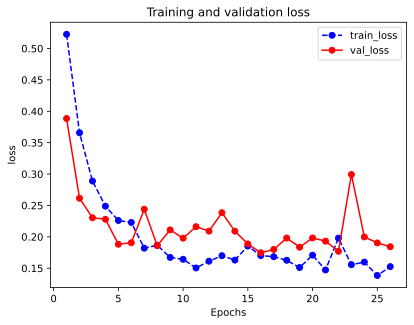

In [21]:
plot_metric(dfhistory,"loss")

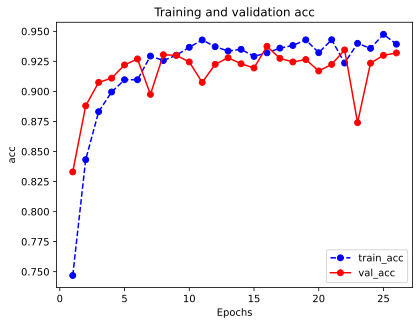

In [22]:
# 调用 plot_metric 函数绘制准确率曲线
plot_metric(dfhistory,"acc")

### 五，使用模型

In [25]:
def predict(net, dl):
    # 将模型设置为评估模式
    # 在评估模式下，dropout层不会随机丢弃神经元，batch normalization层使用全局统计量而非批次统计量
    net.eval()
    
    # 禁用梯度计算，减少内存消耗并加速推理过程
    # 在预测过程中不需要计算梯度，因为不会进行反向传播
    with torch.no_grad():
        # 收集数据加载器中所有批次的预测结果
        # torch.cat将多个张量按指定维度连接起来
        # net.forward等同于net(t[0])，对输入数据进行前向传播
        # 对预测结果使用Sigmoid函数将输出压缩到[0,1]范围，表示概率
        result = nn.Sigmoid()(torch.cat([net(t[0]) for t in dl]))
    
    # 返回预测结果的概率值
    # .data会创建一个新的张量，与计算图分离，只包含数据
    return result.data


In [26]:
# 预测概率
y_pred_probs = predict(net, dl_val)
y_pred_probs

tensor([[1.5529e-02],
        [4.3073e-03],
        [8.0077e-04],
        ...,
        [9.9906e-01],
        [9.9849e-01],
        [3.5145e-01]])

In [27]:
# 预测类别
y_pred = torch.where(y_pred_probs > 0.5,
                     torch.ones_like(y_pred_probs),  # 如果概率 > 0.5，预测为 1
                     torch.zeros_like(y_pred_probs))  # 否则，预测为 0
y_pred

tensor([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [0.]])

### 六，保存模型

推荐使用保存参数方式保存Pytorch模型。

In [28]:
print(net.state_dict().keys()) # 打印模型的所有参数名

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'linear1.weight', 'linear1.bias', 'linear2.weight', 'linear2.bias'])


In [29]:
# 保存模型参数到文件
torch.save(net.state_dict(), "./data/net_parameter.pt")

# 创建一个新的模型实例
net_clone = Net()
# 加载保存的模型参数
net_clone.load_state_dict(torch.load("./data/net_parameter.pt",weights_only=True))

# 使用加载的模型进行预测
predict(net_clone,dl_val)

tensor([[1.5529e-02],
        [4.3073e-03],
        [8.0077e-04],
        ...,
        [9.9906e-01],
        [9.9849e-01],
        [3.5145e-01]])